# Project: Wrangling and Analyzing WeRateDogs Information

Hey there folks! Throughout this notebook, we'll be analyzing information from the illustrious WeRateDogs Twitter account. This Twitter account is all about rating dogs traditionally on a scale of 10, and as you'll notice, almost all dogs rate above a 10 because, well, why would you rate a dog any less?? We'll be collecting data from number of different sources, cleaning up that data for quality and tidiness issues, and finally making some assessments based off our cleaned data.

Without further ado, let's get into it! (Woof, woof!)

<img src='https://pbs.twimg.com/profile_images/1110029608794161152/2SIlO9FZ_400x400.jpg' style='width: 200px'/>

# Table of Contents

 - <a href='#gathering_main'>Gathering the Data</a>
     - <a href='#gathering_local'>Importing from the Local Twitter Archive</a>
     - <a href='#gathering_api'>Importing the JSON information from the Tweepy API</a>
     - <a href='#gathering_html'>Importing Image Prediction Data from Provided Link</a>
 - <a href='#assessing_main'>Assessing the Data</a>
     - <a href='#assessing_manual'>Manual Assessment</a>
     - <a href='#assessing_programmatic'>Programmatic Assessment</a>
     - <a href='#assessing_cleanliness_issues'>Cleanliness Issues</a>
 - <a href='#cleaning_main'>Cleaning the Data</a>
     - <a href='#cleaning_quality_clean_up'>Quality Clean Up</a>
     - <a href='#cleaning_tidiness_clean_up'>Tidiness Clean Up</a>
 - <a href='#analyzing_main'>Analyzing the Data</a>
     - <a href='#analyzing_insight1'>Insight 1: Does It Matter If You're a Woofer?</a>
     - <a href='#analyzing_insight2'>Insight 2: Better Time of Year for Retweets?</a>
     - <a href='#analyzing_insight3'>Insight 3: What's So Special About Those Outliers?</a>

### Imports

Of course, we can't begin without first importing what we need.

In [21]:
#Importing packages we'll need for this project
import os
import json
import numpy as np
import pandas as pd
import tweepy
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.dates
import matplotlib.pyplot as plt
% matplotlib inline

<a id='gathering_main'></a>

## Gathering the Data

Throughout this section, we'll go through a number of different channels to gather the data in it's "raw" form to be utilized through the remainder of the project. These three channels include:

 - A local upload
 - A programatic download from a provided HTML link
 - Usage of Twitter's tweepy API

Notes are provided along the way. Without further ado, let's gather... that... data!

<a id='gathering_local'></a>

### Importing the Local Twitter Archive

In this section, we'll download the 'twitter-archive-enhanced.csv' file provided directly from Udacity, upload it to the Jupyter working environment, and finally read it into a pandas dataframe as 'local_df'.

In [51]:
#Importing local archive as local_df
local_df = pd.read_csv('twitter-archive-enhanced.csv')
local_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<a id='gathering_api'></a>

### Importing the JSON information from the Tweepy API

In this section, we'll download the JSON-formatted information from the Tweepy API by first authenticating my API credentials, populated a JSON dictionary from the API utilizing local_df's tweet IDs, writing the JSON to a text file ('tweets_json.txt'), and finally creating a pandas dataframe ('tweet_json_df') based on the information stored in 'tweets_json.txt'.

**Note**: It took so long to get the API working that I'm utilizing the results in the tweets_json.txt and failed_tweets.txt as my final end result. This way, I don't have to run the darned API every time I close out this notebook and return to it. :)

In [3]:
#Twitter API Authentication; Actual authentication information has been wiped for submission

consumer_key = 'WIPED FOR ASSESSMENT'
consumer_secret = 'WIPED FOR ASSESSMENT'
access_token = 'WIPED FOR ASSESSMENT'
access_secret = 'WIPED FOR ASSESSMENT'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

In [4]:
#Testing Tweepy authentication success by printing my name

print(api.me().name)

David Hundley


In [6]:
#Segment tweet_ids away from the local archive dataframe

tweet_ids = local_df['tweet_id']

In [15]:
#Build the tweets_dict json from the tweepy API

tweets_dict = []
failed_tweets = []

for tweet in tweet_ids:
    try:
        tweet_status = api.get_status(tweet)
        tweets_dict.append(tweet_status._json)
    except:
        failed_tweets.append(tweet)
        
print('Number of successful tweets: {}'.format(len(tweets_dict)))
print('Number of unsuccessful tweets: {}'.format(len(failed_tweets)))

Rate limit reached. Sleeping for: 729
Rate limit reached. Sleeping for: 730
Number of successful tweets: 2339
Number of unsuccessful tweets: 17


In [16]:
#Writing tweets_dict to tweets_json.txt file

with open('tweets_json.txt', 'w') as file:
    file.write(json.dumps(tweets_dict, indent=4))

In [23]:
#Writing failed_tweets to failed_tweets.txt file...
#...because I'm tired of having to run this API every time, so this is the data I'm using folks *smiley face!*

with open('failed_tweets.txt', 'w') as file:
    file.write(str(failed_tweets))

In [52]:
#Building twitter_json_df from tweets_json.txt using the reference URLs below as reference for interested data fields:
#https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object.html
#https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
#Fields to add: id, source, retweet_count, favorite_count, retweeted

interested_data = []

with open('tweets_json.txt', 'r') as file:
    json_data = json.load(file)
    for tweet in json_data:
        tweet_id = tweet['id']
        text = tweet['text']
        tweet_source = tweet['source']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        retweeted = tweet['retweeted']
        
        interested_data.append({'id': tweet_id,
                                'text': text,
                                'source': tweet_source,
                                'retweet_count': retweet_count,
                                'favorite_count': favorite_count,
                                'retweeted': retweeted})
        
tweet_json_df = pd.DataFrame(interested_data, columns=['id', 'text', 'source', 'retweet_count', 'favorite_count', 'retweeted'])

In [53]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 6 columns):
id                2339 non-null int64
text              2339 non-null object
source            2339 non-null object
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
retweeted         2339 non-null bool
dtypes: bool(1), int64(3), object(2)
memory usage: 93.7+ KB


<a id='gathering_html'></a>

### Importing Image Prediction Data from Provided Link

In this section, we'll pull in the image prediction data from the provided link using the handy dandy Requests package.

In [54]:
#Getting a response from the URL utilizing Requests, and then writing the content of that response to the 'image_predictions.tsv' file

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [55]:
#Importing the 'image_predictions_tsv' file into a pandas dataframe called 'image_predictions_df'

image_predictions_df = pd.read_csv('image_predictions.tsv', sep = '\t')

In [56]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='assessing_main'></a>

## Assessing the Data

Now that we've successfully imported our data sets, we'll spend this section assessing the datasets both manually and progammatically. Toward the bottom of this assessment, we'll make notes on tidiness / quality issues that we'll address down in the next "Cleaning the Data" section.

<a id='assessing_manual'></a>

### Manual Assessment

Looking at the data in its pure form.

In [57]:
#Checking out the data from the local archive file

local_df.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [58]:
#Checking out the data from the Twitter API

tweet_json_df.head(20)

,id,text,source,retweet_count,favorite_count,retweeted
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"<a href=""http://twitter.com/download/iphone"" r...",8225,37737,False
1,892177421306343426,This is Tilly. She's just checking pup on you....,"<a href=""http://twitter.com/download/iphone"" r...",6079,32419,False
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"<a href=""http://twitter.com/download/iphone"" r...",4023,24421,False
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,"<a href=""http://twitter.com/download/iphone"" r...",8378,41070,False
4,891327558926688256,This is Franklin. He would like you to stop ca...,"<a href=""http://twitter.com/download/iphone"" r...",9082,39262,False
5,891087950875897856,Here we have a majestic great white breaching ...,"<a href=""http://twitter.com/download/iphone"" r...",3011,19747,False
6,890971913173991426,Meet Jax. He enjoys ice cream so much he gets ...,"<a href=""http://twitter.com/download/iphone"" r...",1991,11545,False
7,890729181411237888,When you watch your owner call another dog a g...,"<a href=""http://twitter.com/download/iphone"" r...",18279,63667,False
8,890609185150312448,This is Zoey. She doesn't want to be one of th...,"<a href=""http://twitter.com/download/iphone"" r...",4137,27127,False
9,890240255349198849,This is Cassie. She is a college pup. Studying...,"<a href=""http://twitter.com/download/iphone"" r...",7144,31117,False


In [59]:
#Checking out the data from the image predictions file

image_predictions_df.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


<a id='assessing_programmatic'></a>

### Programmatic Assessment

Now that we've done a manual assessment, let's run some methods on the datasets to understand additional info from a programmatic perspective.

#### Local Twitter Archive File

In [60]:
local_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [61]:
local_df['retweeted_status_id'].value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
8.780576e+17    1
7.320056e+17    1
7.186315e+17    1
6.732953e+17    1
7.914070e+17    1
8.447048e+17    1
7.862340e+17    1
8.685523e+17    1
7.504293e+17    1
8.327664e+17    1
6.690004e+17    1
6.873173e+17    1
7.638376e+17    1
7.815247e+17    1
8.092201e+17    1
8.000650e+17    1
8.174239e+17    1
8.001414e+17    1
7.909461e+17    1
7.867091e+17    1
8.406323e+17    1
8.688804e+17    1
7.869631e+17    1
7.733088e+17    1
8.222448e+17    1
               ..
6.816941e+17    1
7.899865e+17    1
7.939622e+17    1
6.800555e+17    1
7.128090e+17    1
8.164506e+17    1
6.769365e+17    1
6.675487e+17    1
8.083449e+17    1
7.626999e+17    1
6.678667e+17    1
8.479710e+17    1
6.820881e+17    1
8.352641e+17    1
7.761133e+17    1
7.902771e+17    1
6.675484e+17    1
7.677549e+17    1
8.782815e+17    1
8.663350e+17    1
7.399792e+17    1
7.403732e+17    1
8.395493e+17    1
7.001438e+17    1
8.482894e+

In [62]:
local_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [63]:
local_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [64]:
local_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [65]:
local_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [66]:
local_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [67]:
local_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [68]:
local_df['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
the            8
Sadie          8
Buddy          7
Bailey         7
an             7
Daisy          7
Toby           7
Dave           6
Stanley        6
Jax            6
Bella          6
Milo           6
Jack           6
Oscar          6
Leo            6
Rusty          6
Scout          6
Koda           6
Gus            5
            ... 
Hanz           1
Aja            1
Bonaparte      1
Puff           1
Huck           1
Lacy           1
Kallie         1
Grizz          1
Carll          1
Shnuggles      1
Vinscent       1
Kanu           1
Opie           1
Toffee         1
Chuck          1
Maks           1
Pavlov         1
Rey            1
Kuyu           1
Ziva           1
Jazzy          1
Kendall        1
Shikha         1
Jim            1
Fillup         1
Rolf           1
Bones          1
Hall          

#### Twitter API Dataset

In [69]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 6 columns):
id                2339 non-null int64
text              2339 non-null object
source            2339 non-null object
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
retweeted         2339 non-null bool
dtypes: bool(1), int64(3), object(2)
memory usage: 93.7+ KB


In [70]:
tweet_json_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2205
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

#### Image Prediction Dataset

In [71]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [72]:
image_predictions_df['jpg_url'].value_counts()

https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg                                            2
https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg                                            2
https://pbs.twimg.com/media/Cbs3DOAXIAAp3Bd.jpg                                            2
https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg                                            2
https://pbs.twimg.com/media/Cx5R8wPVEAALa9r.jpg                                            2
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg                                            2
https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg                       

In [73]:
image_predictions_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

<a id='assessing_cleanliness_issues'></a>

### Cleanliness Issues

Now that we've done our manual and programmatic assessments, I've made some notes below where I think the data can be cleaned up from both a tidiness perspective and quality perspective. We'll use these notes to actually clean up the issues down in the next section.

#### Quality Issues

 - Cleaning up the source column in local_df
 - Cleaning up the source column in tweet_json_df
 - Extracting the rating from the text in tweet_json_df
 - Dropping rows with missing values for rating in tweet_json_df
 - Adjusting the timepstamp in local_df to only reflect date and not time
 - Dropping retweeted rows from local_df (since they are essentially duplicating information)
 - Dropping retweeted rows from tweet_json_df (since they are essentially duplicating information)
 - Providing more descriptive column names in image_predictions_df since I found them confusing
 - Adjusting the letter case on each value in the prediction columns to match all upper/lowercase names to be a consistent format
 - Dropping missed rows from all tables where the Twitter API failed to gather information on a specific ID
 - Adjusting ID column name in the image predictions dataset

#### Tidiness Issues

 - There are many columns that can be dropped from the datasets altogether as they won't be used in our final assessments. These columns include...
     - From local_df
         - in_reply_to_status_id
         - in_reply_to_user_id
         - expanded_urls
         - text
         - rating_numerator (since we'll merge in the one from the API later)
         - rating_denominator (since we'll merge in the one from the API later)
     - From tweet_json_df
         - retweeted
     - From image_predictions_df
         - jpg_url
 - The dog categories like floofer, puppo, and more are each its own column and can really be combined into one column  with different representing values
 - Finally... all three of these datasets can really be combined into a singular one due to the nature of their adjoining content

<a id='cleaning_main'></a>

## Cleaning the Data

Alrighty, now that we've imported our data and gone through our assessments, it's time to clean up our data and make it look nice and pretty. Throughout this section, we'll cover the quality / tidiness issues delineated at the end of the last section. We'll do this first by defining the solution to our issue, writing the code for that solution, and finally testing it out to see that it's all fine and good.

(Oh yeah... before we get into cleaning, let's make some clean dataset copies from the originals to work with, shall we?)

In [74]:
local_df_clean = local_df.copy()
tweet_json_df_clean = tweet_json_df.copy()
image_predictions_df_clean = image_predictions_df.copy()

<a id='cleaning_quality_clean_up'></a>

### Quality Clean Up

#### Cleaning up the source column in local_df

***Define***

We'll create a lambda function that utilizes Beautiful Soup to extract the text from the HTML tag and then put it back into the source column looking nice and neat.

(Special thanks to this Stack Overflow post for helping me with this: https://stackoverflow.com/questions/44703945/pandas-trouble-stripping-html-tags-from-dataframe-column.)

***Code***

In [75]:
local_df_clean['source'] = local_df_clean['source'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

***Test***

In [76]:
local_df_clean['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

#### Cleaning up the source column in tweet_json_df

***Define***

Same thing as our last rodeo, only this time around in the tweet_json_df dataset. We'll create a lambda function that utilizes Beautiful Soup to extract the text from the HTML tag and then put it back into the source column looking nice and neat.

(Special thanks again to this Stack Overflow post for helping me with this: https://stackoverflow.com/questions/44703945/pandas-trouble-stripping-html-tags-from-dataframe-column.)

***Code***

In [77]:
tweet_json_df_clean['source'] = tweet_json_df_clean['source'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

***Test***

In [78]:
tweet_json_df_clean['source'].value_counts()

Twitter for iPhone     2205
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                10
Name: source, dtype: int64

#### Extracting the rating from the text in tweet_json_df

***Define***

Let's work some regex magic to get the rating we find in the body of the tweet text as listed retrieved from the Twitter API.

(Special thanks to my fellow comrades in the Udacity student forum for the help here: https://knowledge.udacity.com/questions/33009)

***Code***

In [79]:
#Using regex to extract the rating from the text and then rejoining it to the dataframe
rating = tweet_json_df_clean['text'].str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
tweet_json_df_clean = tweet_json_df_clean.join(rating)

In [80]:
#Renaming the columns appropriately
tweet_json_df_clean.rename(columns={0: 'rating_numerator', 1: 'rating_denominator'}, inplace=True)

In [81]:
#Dropping the text column since we don't really need it anymore
tweet_json_df_clean.drop(columns='text', axis=1, inplace=True)

***Test***

In [82]:
tweet_json_df_clean.head(5)

,id,source,retweet_count,favorite_count,retweeted,rating_numerator,rating_denominator
0,892420643555336193,Twitter for iPhone,8225,37737,False,13,10
1,892177421306343426,Twitter for iPhone,6079,32419,False,NaN,NaN
2,891815181378084864,Twitter for iPhone,4023,24421,False,NaN,NaN
3,891689557279858688,Twitter for iPhone,8378,41070,False,13,10
4,891327558926688256,Twitter for iPhone,9082,39262,False,NaN,NaN


#### Filling in rows with missing rating values in tweet_json_df

***Define***

For the rows missing rating information in tweet_json_df, we'll go ahead and pull and fill from the archived information in local_df_clean

(EXTRA special thanks to this Stack Overflow post for help: https://stackoverflow.com/questions/29357379/pandas-fill-missing-values-in-dataframe-from-another-dataframe)

***Code***

In [83]:
#Renaming the column in local_df_clean to work with the next step
local_df_clean.rename(columns={'tweet_id': 'id'}, inplace=True)

In [84]:
#Segmenting out the info we'll need to fill in the null values
archived_parameters = local_df_clean[['id', 'rating_numerator', 'rating_denominator']]

In [85]:
#FIlling in the null values with the archived parameters
tweet_json_df_clean = tweet_json_df_clean.fillna(archived_parameters)

***Test***

In [86]:
tweet_json_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 7 columns):
id                    2339 non-null int64
source                2339 non-null object
retweet_count         2339 non-null int64
favorite_count        2339 non-null int64
retweeted             2339 non-null bool
rating_numerator      2339 non-null object
rating_denominator    2339 non-null object
dtypes: bool(1), int64(3), object(3)
memory usage: 112.0+ KB


#### Adjusting the timestamp in local_df to only reflect date and not time

***Define***

Since the 'timestamp' column, we'll first have to convert it into datetime. Then we'll create a new column 'date' by extracting the proper info from 'timestamp' into a year-month-day format. And finally, we'll drop the original 'timestamp' column.

***Code***

In [87]:
#Changing the timestamp type from string to datetime
local_df_clean['timestamp'] = pd.to_datetime(local_df_clean['timestamp'])

In [88]:
#Creating a new column called "Date" and extracting date information into that from timestamp
local_df_clean['date'] = local_df_clean['timestamp'].apply(lambda time: time.strftime('%Y-%m-%d'))

In [89]:
#Dropping the timestamp column
local_df_clean.drop(columns='timestamp', axis=1, inplace=True)

***Test***

In [90]:
local_df_clean['date']

0       2017-08-01
1       2017-08-01
2       2017-07-31
3       2017-07-30
4       2017-07-29
5       2017-07-29
6       2017-07-28
7       2017-07-28
8       2017-07-27
9       2017-07-26
10      2017-07-26
11      2017-07-25
12      2017-07-25
13      2017-07-25
14      2017-07-24
15      2017-07-24
16      2017-07-23
17      2017-07-22
18      2017-07-22
19      2017-07-21
20      2017-07-20
21      2017-07-19
22      2017-07-19
23      2017-07-19
24      2017-07-18
25      2017-07-18
26      2017-07-17
27      2017-07-16
28      2017-07-16
29      2017-07-15
           ...    
2326    2015-11-17
2327    2015-11-17
2328    2015-11-16
2329    2015-11-16
2330    2015-11-16
2331    2015-11-16
2332    2015-11-16
2333    2015-11-16
2334    2015-11-16
2335    2015-11-16
2336    2015-11-16
2337    2015-11-16
2338    2015-11-16
2339    2015-11-16
2340    2015-11-16
2341    2015-11-16
2342    2015-11-16
2343    2015-11-16
2344    2015-11-16
2345    2015-11-16
2346    2015-11-16
2347    2015

#### Dropping retweeted rows from local_df (since they are essentially duplicating information)

***Define***

We'll leverage the retweeted column information to know whether or not a particular line was retweeted, and if so, we'll go ahead and drop that particular row.

***Code***

In [91]:
#Dropping the rows that have populated values for 'retweeted_status_id'
local_df_clean = local_df_clean[local_df_clean['retweeted_status_id'].isnull()]

In [92]:
#Dropping the columns that have to do with retweeted info
local_df_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

***Test***

In [93]:
local_df_clean.head(1)

,id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date
0,892420643555336193,NaN,NaN,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,2017-08-01


#### Dropping retweeted rows from tweet_json_df (since they are essentially duplicating information)

***Define***

Simply rebuilding the dataframe by selecting only rows with a retweeted value of False

***Code***

In [94]:
tweet_json_df_clean = tweet_json_df_clean[tweet_json_df_clean['retweeted'] == False]

***Test***

In [95]:
(tweet_json_df_clean['retweeted'] == True).sum()

0

#### Providing more descriptive column names in image_predictions_df since I found them confusing

***Define***

Renaming the column names appropriately using the rename method

***Code***

In [96]:
image_predictions_df_clean.rename(columns={'p1': 'prediction1',
                                           'p1_conf': 'prediction1_confidence',
                                           'p1_dog': 'prediction1_isdog',
                                           'p2': 'prediction2',
                                           'p2_conf': 'prediction2_confidence',
                                           'p2_dog': 'prediction2_isdog',
                                           'p3': 'prediction3',
                                           'p3_conf': 'prediction3_confidence',
                                           'p3_dog': 'prediction3_isdog'}, inplace = True)

***Test***

In [97]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
img_num                   2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_isdog         2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_isdog         2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_isdog         2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Adjusting the letter case on each value in the prediction columns to match all upper/lowercase names to be a consistent format

***Define***

Simply using the 'lower' method on the appropriate columns to make everything lowercase

***Code***

In [98]:
image_predictions_df_clean['prediction1'] = image_predictions_df_clean['prediction1'].str.lower()
image_predictions_df_clean['prediction2'] = image_predictions_df_clean['prediction2'].str.lower()
image_predictions_df_clean['prediction3'] = image_predictions_df_clean['prediction3'].str.lower()

***Test***

In [99]:
image_predictions_df_clean.head()

,tweet_id,jpg_url,img_num,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### Dropping missed rows from all tables where the Twitter API failed to gather information on a specific ID

***Define***

Loading up the failed tweet IDS from failed_tweets.txt and then dropping the rows that match those IDs from the respective datasets

***Code***

In [100]:
#Importing the failed tweets from failed_tweets.txt

failed_tweets = []
with open('failed_tweets.txt', 'r') as file:
    failed_tweets = json.load(file)

In [101]:
#Filtering out those rows with the failed tweet IDs in local_df_clean
local_df_clean = local_df_clean[~local_df_clean['id'].isin(failed_tweets)]

In [102]:
#Filtering out those rows with the failed tweet IDs in image_predictions_df_clean
image_predictions_df_clean = image_predictions_df_clean[~image_predictions_df_clean['tweet_id'].isin(failed_tweets)]

***Test***

In [103]:
(local_df_clean['id'].isin(failed_tweets)).sum()

0

In [104]:
(image_predictions_df_clean['tweet_id'].isin(failed_tweets)).sum()

0

#### Adjusting ID column name in the image predictions dataset

***Define***

Adding one last piece in here to adjust the ID column name in the image prediction set from tweet_id to id using the rename function

***Code***

In [105]:
image_predictions_df_clean.rename(columns={'tweet_id': 'id'}, inplace=True)

***Test***

In [106]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2074
Data columns (total 12 columns):
id                        2066 non-null int64
jpg_url                   2066 non-null object
img_num                   2066 non-null int64
prediction1               2066 non-null object
prediction1_confidence    2066 non-null float64
prediction1_isdog         2066 non-null bool
prediction2               2066 non-null object
prediction2_confidence    2066 non-null float64
prediction2_isdog         2066 non-null bool
prediction3               2066 non-null object
prediction3_confidence    2066 non-null float64
prediction3_isdog         2066 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 167.5+ KB


<a id='cleaning_tidiness_clean_up'></a>

### Tidiness Clean Up

#### There are many columns that can be dropped from the datasets altogether as they won't be used in our final assessments. These columns include...

 - From local_df
     - in_reply_to_status_id
     - in_reply_to_user_id
     - expanded_urls
     - text
     - rating_numerator (since we'll merge in the one from the API later)
     - rating_denominator (since we'll merge in the one from the API later)
     - source (since we'll merge in the one from the API later)
 - From tweet_json_df
     - retweeted
 - From image_predictions_df
     - img_num

***Define***

Lots and lots of using that drop functionality!

***Code***

In [107]:
#From local_df_clean, we'll drop in_reply_to_status_id, in_reply_to_user_id, text, expanded_urls, rating_numerator, rating_denominator, source
local_df_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'source'], inplace=True)

In [108]:
#From tweet_json_df_clean, we'll drop just the retweeted column
tweet_json_df_clean.drop(columns='retweeted', axis=1, inplace=True)

In [109]:
#From image_predictions_df_clean, we'll drop img_num
image_predictions_df_clean.drop(columns=['img_num'], inplace=True)

***Test***

In [110]:
local_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2355
Data columns (total 7 columns):
id         2172 non-null int64
name       2172 non-null object
doggo      2172 non-null object
floofer    2172 non-null object
pupper     2172 non-null object
puppo      2172 non-null object
date       2172 non-null object
dtypes: int64(1), object(6)
memory usage: 135.8+ KB


In [111]:
tweet_json_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 6 columns):
id                    2339 non-null int64
source                2339 non-null object
retweet_count         2339 non-null int64
favorite_count        2339 non-null int64
rating_numerator      2339 non-null object
rating_denominator    2339 non-null object
dtypes: int64(3), object(3)
memory usage: 127.9+ KB


In [112]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2074
Data columns (total 11 columns):
id                        2066 non-null int64
jpg_url                   2066 non-null object
prediction1               2066 non-null object
prediction1_confidence    2066 non-null float64
prediction1_isdog         2066 non-null bool
prediction2               2066 non-null object
prediction2_confidence    2066 non-null float64
prediction2_isdog         2066 non-null bool
prediction3               2066 non-null object
prediction3_confidence    2066 non-null float64
prediction3_isdog         2066 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 151.3+ KB


#### The dog categories like floofer, puppo, and more are each its own column and can really be combined into one column  with different representing values

***Define***

Melting down the local_df_clean dataframe to merge the "woofer" columns into one

(Thank you to this Stack Overflow for help: https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest)

***Code***

In [113]:
#Melting down the local_df_clean_dataframe
local_df_clean = pd.melt(local_df_clean, id_vars=['id', 'name', 'date'],
             var_name='woofer_class', value_name='woofer_type')

In [114]:
#Dropping the duplicates based on duplicated IDs
local_df_clean = local_df_clean.drop_duplicates(subset='id', keep='last')

In [115]:
#Dropping the woofer_class column as it's not really helpful
local_df_clean.drop(columns='woofer_class', axis=1, inplace=True)

***Test***

In [116]:
local_df_clean.head()

,id,name,date,woofer_type
6516,892420643555336193,Phineas,2017-08-01,None
6517,892177421306343426,Tilly,2017-08-01,None
6518,891815181378084864,Archie,2017-07-31,None
6519,891689557279858688,Darla,2017-07-30,None
6520,891327558926688256,Franklin,2017-07-29,None


In [117]:
local_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 6516 to 8687
Data columns (total 4 columns):
id             2172 non-null int64
name           2172 non-null object
date           2172 non-null object
woofer_type    2172 non-null object
dtypes: int64(1), object(3)
memory usage: 84.8+ KB


#### Finally... all three of these datasets can really be combined into a singular one due to the nature of their adjoining content

***Define***

First we'll merge the image predictions dataset into the JSON dataset, and then we'll merge that dataset with the local archive dataset

***Code***

In [118]:
#Merging image_predictions_df_clean into tweet_json_df_clean with a right join
df_merged = pd.merge(tweet_json_df_clean, image_predictions_df_clean, on='id', how='right')

In [119]:
df_merged

,id,source,retweet_count,favorite_count,rating_numerator,rating_denominator,jpg_url,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog
0,892420643555336193,Twitter for iPhone,8225,37737,13,10,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,Twitter for iPhone,6079,32419,13,10,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,Twitter for iPhone,4023,24421,12,10,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,Twitter for iPhone,8378,41070,13,10,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,Twitter for iPhone,9082,39262,12,10,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
5,891087950875897856,Twitter for iPhone,3011,19747,13,10,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False
6,890971913173991426,Twitter for iPhone,1991,11545,13,10,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,Twitter for iPhone,18279,63667,13,10,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True
8,890609185150312448,Twitter for iPhone,4137,27127,13,10,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True
9,890240255349198849,Twitter for iPhone,7144,31117,14,10,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True


In [120]:
#Merging the local archive info with df_merged using a left join
df_master = pd.merge(df_merged, local_df_clean, on='id', how='left')

In [121]:
#Because I have been up for hours and don't feel like figuring it out anymore, I'm dropping some weirdo rows that are now acting null
df_master = df_master.dropna()

In [122]:
#And finally, let's reorder the columns just because
df_master = df_master[['id', 'name', 'woofer_type', 'date', 'source', 'retweet_count', 'favorite_count',
                'rating_numerator', 'rating_denominator', 'prediction1', 'prediction1_confidence',
                'prediction1_isdog', 'prediction2', 'prediction2_confidence', 'prediction2_isdog',
                'prediction3', 'prediction3_confidence', 'prediction3_isdog', 'jpg_url']]

***Test***

In [123]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2065
Data columns (total 19 columns):
id                        1991 non-null int64
name                      1991 non-null object
woofer_type               1991 non-null object
date                      1991 non-null object
source                    1991 non-null object
retweet_count             1991 non-null int64
favorite_count            1991 non-null int64
rating_numerator          1991 non-null object
rating_denominator        1991 non-null object
prediction1               1991 non-null object
prediction1_confidence    1991 non-null float64
prediction1_isdog         1991 non-null bool
prediction2               1991 non-null object
prediction2_confidence    1991 non-null float64
prediction2_isdog         1991 non-null bool
prediction3               1991 non-null object
prediction3_confidence    1991 non-null float64
prediction3_isdog         1991 non-null bool
jpg_url                   1991 non-null object
dtypes

### Saving to Master CSV

Friends... We've come a long way. We've scrounged. We've scrabbled. We've cleaned like tasmanian devils. (Do tasmanian devils clean...? I don't know. All I know is that I spent the last 8 hours straight cleaning data and am ready to go to BED.)

Let's save this bad boy to our master CSV and get back to our analysis later.

In [124]:
df_master.to_csv('twitter_archive_master.csv', index=False)

<a id='analyzing_main'></a>
# Analyzing the Data

Okay, folks! Now that we have nice and clean dataset to work with, we'll round off this notebook with a number of insights we'll gather from looking at the data.

In [125]:
df_master = pd.read_csv('twitter_archive_master.csv')

In [126]:
df_master.head()

,id,name,woofer_type,date,source,retweet_count,favorite_count,rating_numerator,rating_denominator,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog,jpg_url
0,892420643555336193,Phineas,None,2017-08-01,Twitter for iPhone,8225,37737,13.0,10.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,Tilly,None,2017-08-01,Twitter for iPhone,6079,32419,13.0,10.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,Archie,None,2017-07-31,Twitter for iPhone,4023,24421,12.0,10.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,Darla,None,2017-07-30,Twitter for iPhone,8378,41070,13.0,10.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,Franklin,None,2017-07-29,Twitter for iPhone,9082,39262,12.0,10.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


<a id='analyzing_insight1'></a>
## Insight #1: Does it matter if you're a 'woofer'?

'Woofer' is my collective reference to any dog that had a special label like 'puppo', 'floofer', and more. Many of these dogs didn't have a special label like that! :( This doesn't mean that dogs with those labels are any better... or does it? I was curious to see, so I grouped all dogs together WITH the 'woofer' label and WITHOUT the 'woofer' label to get a sense if there was truly any disparity between the two.

In [127]:
#Adding a boolean value to determine whether or not a dog has a 'woofer' label
df_master['woofer_bool'] = df_master['woofer_type'] != 'None'

In [128]:
#Creating values we'll use later
is_woofer = (df_master['woofer_bool'] == True).sum()
not_woofer = (df_master['woofer_bool'] == False).sum()
is_woofer_favorited_mean = df_master[df_master['woofer_bool'] == True]['favorite_count'].mean()
not_woofer_favorited_mean = df_master[df_master['woofer_bool'] == False]['favorite_count'].mean()

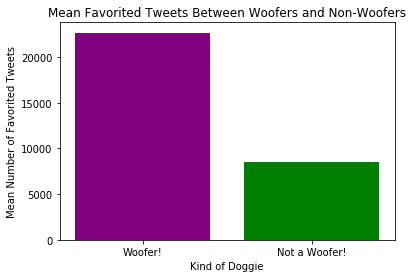

In [129]:
#Creating our chart!
objects = (is_woofer, not_woofer)
y_pos = np.arange(len(objects))
heights = [is_woofer_favorited_mean, not_woofer_favorited_mean]
plt.bar(y_pos, heights, color=['purple', 'green']);
plt.title('Mean Favorited Tweets Between Woofers and Non-Woofers')
plt.ylabel('Mean Number of Favorited Tweets');
plt.xlabel('Kind of Doggie');
plt.xticks(y_pos, ['Woofer!', 'Not a Woofer!']);

### Insight #1 Conclusion

Well.... ummmm... all dogs are still created equal, right?

Actually, this is definitely an unfair comparison. The reason for this is that the number of dogs that got the 'woofer' label were extraordinarily low compared to dogs without the 'woofer' label. Still, it would merit some interest in the future to see what would happen if WeRateDogs was more intentional about adding these special labels. Would those dogs get more favorites? Maybe. But I'm going to label this one as inconclusive.

<a id='analyzing_insight2'></a>
## Insight #2: Better Time of Year for Retweets?

We'd like to think we're equally as kind and generous year round, but let's be honest: we have a tendency to be NICER around the holidays. That said, I was specifically curious to see if tweets generally favored better around the end of a given year. We worked with Favorites last time, so this time, let's plot out number of retweets instead.

(Thanks to this Stack Overflow for helping me plot items over time: https://stackoverflow.com/questions/1574088/plotting-time-in-python-with-matplotlib.)

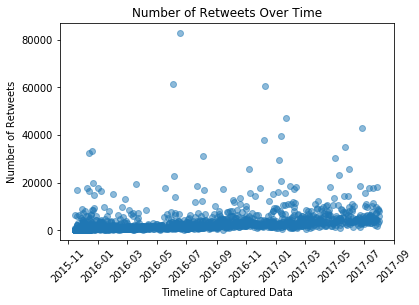

In [130]:
#Using our 'date' column as our timeline, we'll build a date plot using that as the timeline and our retweet_count as our actual values
timeline = pd.to_datetime(df_master['date'])
timeline = timeline.values
plt.plot_date(timeline, df_master['retweet_count'], alpha = .5);
plt.xticks(rotation=45);
plt.title('Number of Retweets Over Time');
plt.xlabel('Timeline of Captured Data');
plt.ylabel('Number of Retweets');

### Insight #2 Conclusion

The outliers make this one really difficult to see. Generally speaking, however, I think our visual analysis here doesn't give any credence to my hypothesis that people retweet around the holidays. If I do see one thing here, however, it's that number of retweets over time seems to be increasing in general. If I had to guess, I'd attribute that the the proportionate growth in number of users over time. (Or in layman's terms, mo' users, mo' retweets.)

<a id='analyzing_insight3'></a>
## Insight #3: What's So Special About Those Outliers?
For our last insight, I was very curious to see why some of these dogs got extremely high ratings when most other dogs got around a score of 11 or 12. For that, I'll take the top 3 dogs AND the 2 bottom dogs and see why.

In [131]:
df_master['rating_numerator'].value_counts().sort_index(ascending=False)

1776.00      1
420.00       1
204.00       1
182.00       1
165.00       1
144.00       1
143.00       1
121.00       1
99.00        1
88.00        1
84.00        1
80.00        1
75.00        1
60.00        1
50.00        1
45.00        1
44.00        1
24.00        1
14.00       32
13.50        1
13.00      268
12.00      451
11.26        1
11.00      387
10.00      419
9.75         1
9.00       151
8.00        95
7.00        52
6.00        31
5.00        33
4.00        16
3.00        19
2.00         9
1.00         5
0.00         2
Name: rating_numerator, dtype: int64

In [133]:
#Getting the info on our top dog (pun totally intended)
df_master[df_master['rating_numerator'] == 1776]

,id,name,woofer_type,date,source,retweet_count,favorite_count,rating_numerator,rating_denominator,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog,jpg_url,woofer_bool
724,749981277374128128,Atticus,None,2016-07-04,TweetDeck,2610,5337,1776.0,10.0,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,False


#### Our Top Dog with a Rating of 1776

<img src='https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg' style='width: 200px'/>

Well this is most certainly appropriate, I do say! Should I have expected any less? I do fine it hilarious that the prediction correctly guessed that the dog is wearing a bowtie and hat but couldn't actually figure out what the dog is. But that's okay. With this pooch decked out in full Fourth of July gear, we'll give our computer vision algorithm a patriotic pass.

In [137]:
#Getting the info on our second highest dog
df_master[df_master['rating_numerator'] == 420]

,id,name,woofer_type,date,source,retweet_count,favorite_count,rating_numerator,rating_denominator,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog,jpg_url,woofer_bool
1715,670842764863651840,None,None,2015-11-29,Twitter for iPhone,8880,24756,420.0,10.0,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,False


#### Our Second Highest Dog with a Rating of 420

<img src='https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg' style='width: 200px'/>

Okay... I genuinely was NOT expecting this image. I knew it would be a little dicey given that number, but I was expecting something like a cute pup in a tye dye t-shirt or something, ya know? I can't tell if it's the lack of sleep from mashing through this project, but I laughed so hard when this image loaded. Like... embarrassingly hard. WeRateDogs, you slay me!

Oh, and the image predictor... where the heck did you get "drumstick" from?? Go home, image predictor, you're drunk! (Or high...?)

In [140]:
#Getting the info on our third highest dog
df_master[df_master['rating_numerator'] == 204]

,id,name,woofer_type,date,source,retweet_count,favorite_count,rating_numerator,rating_denominator,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog,jpg_url,woofer_bool
846,731156023742988288,this,None,2016-05-13,Twitter for iPhone,1342,3974,204.0,170.0,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,False


#### Our Third Highest Dog with a Rating of 204

<img src='https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg' style='width: 200px'/>

Alright, I get it now. Multiple dogs = multiple ratings = higher score. I see you, WeRateDogs.

And image predictor... there are no king penguins here.

In [150]:
#Finally, getting info on our two dogs who scored a dead last 0
df_master[df_master['rating_numerator'] == 0]

,id,name,woofer_type,date,source,retweet_count,favorite_count,rating_numerator,rating_denominator,prediction1,prediction1_confidence,prediction1_isdog,prediction2,prediction2_confidence,prediction2_isdog,prediction3,prediction3_confidence,prediction3_isdog,jpg_url,woofer_bool
234,835152434251116546,None,None,2017-02-24,Twitter for iPhone,3209,23416,0.0,10.0,swing,0.967066,False,american_staffordshire_terrier,0.012731,True,staffordshire_bullterrier,0.007039,True,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,False
754,746906459439529985,None,None,2016-06-26,Twitter for iPhone,313,3005,0.0,10.0,traffic_light,0.470708,False,fountain,0.199776,False,space_shuttle,0.064807,False,https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg,False


In [151]:
local_df[local_df['tweet_id'] == 835152434251116546]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None


#### Our Poor Pooches Tied for Last with a Rating of 0

<img src='https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg	' style='width: 200px'/>
<img src='https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg' style='width: 200px'/>

Hmmm... I totally get the cityscape. It's a cityscape, not a dog. Fine.

BUT why. Why oh why the other poor pooch?? What did he do to get a 0??? Actually after doing a little digging, I came to find out that WeRateDogs was being intentionally plagiarized by another Twitter account, so WeRateDogs was giving that OTHER Twitter account a 0/10, not the dog itself. The dog was just caught up in some unfortunate nonsense. Don't worry, buddy, you're still a 13/10 in our eyes.

### Insight #3 Conclusions

That was fun! I'm glad to see that none of these dogs were inherently better than our traditional dogs and simply benefactors (or non-benefactors) of coincidental happenstance.

 Because remember, __[they're good dogs, Brent.](http://knowyourmeme.com/memes/theyre-good-dogs-brent)__ 